# Statistical Learning - Tarea 2


### Realizado por Yurandir Santa Maria Santana Sandoval

### Parte 1 - Modelo exponencial de covid-19 usando feature-eng

Usando el ejemplo de covid-19 en el notebook de feature-eng (https://colab.research.google.com/drive/1sJV2HG7tQgCGKES3-dIclzHQJ9qAWB3b?usp=sharing) crear un modelo de covid-19 para Guatemala.

* Convertir la fecha a un entero "número de día", por ejemplo si se usan datos desde el 22 de abril, este es el día 0, el 23 es el día 1.
* Aplicar regresión lineal sobre la variable "Confirmed" transformada.
* Una vez entrenado el modelo usarlo para aproximar la cantidad de casos confirmados para el 30 de mayo. Se debe reportar la cantidad de casos, no la cantidad transformada obtenida.

### Parte 2 - Modelo polinomial de calidad de vinos

Es permitido utilizar [sklearn.preprocessing.polynomialfeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)


### Instrucciones

1. Seleccionar y transformar(generando las combinaciones polinomiales para un polinomio de grado dos o tres a elección) las features que considere que son las mejores para predecir la calidad del vino, utilizar como minimo 2 features. Para seleccionar las features, hacer un analisis exploratorio por ejemplo(pero no limitado a ):  graficando y viendo la forma en que se comportan los datos.

 Por ejemplo, se tienen las features "a" y "b" y seleccionamos polinomio de grado 2, hacemos feature engineering para obtener :
 
 $[a,b,a^{2},b^{2},ab]$
 
 No olvidar el "bias" (parámetro multiplicado por 1) ,con lo cual el dataset puede quedar con las columnas:
 
 $[1,a,b,a^{2},b^{2},ab]$
2. Una vez transformada la data aplicar regresion lineal con las features polinomiales usando Tensorflow.

Requisitos adicionales:
* Se debe agregar al notebook un screenshot del grafo de tensorboard, simplificando(usando  names , y name_scope como visto en clase).

* Se debe generar un directorio de logs de tensorboard para cada corrida/experimento , con cada directorio identificando facilmente la configuración del experimento como visto en clase, por ejemplo para un experimento con learning rate = 0.1 , y polinomio grado 2  crear un directorio: lr=0.1_polinomio_grado=2. (Agregar al notebook un screenshot de estas gráficas)

* Concluir en markdown cual es el mejor modelo para este caso basado en la comparativa entre curvas de costo/error en tensorboard.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as Sci
import seaborn as sns
import time as time

In [2]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_csv('/content/drive/My Drive/winequality-red.csv')

### Red Wine Quality Data

Se aplicará regresión para crear un modelo de la calidad de vino en función de características del mismo, siendo 1 el peor vino y 10 el mejor.

Variables de entrada:
1. fixed acidity 
2. volatile acidity 
3. citric acid 
4. residual sugar 
5. chlorides 
6. free sulfur dioxide 
7. total sulfur dioxide 
8. density 
9. pH 
10. sulphates 
11. alcohol 

Varaible a predecir: 
12. quality (puntuacion  entre 0 y 10) 



In [6]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### Gráfica - índices de Correlaciones

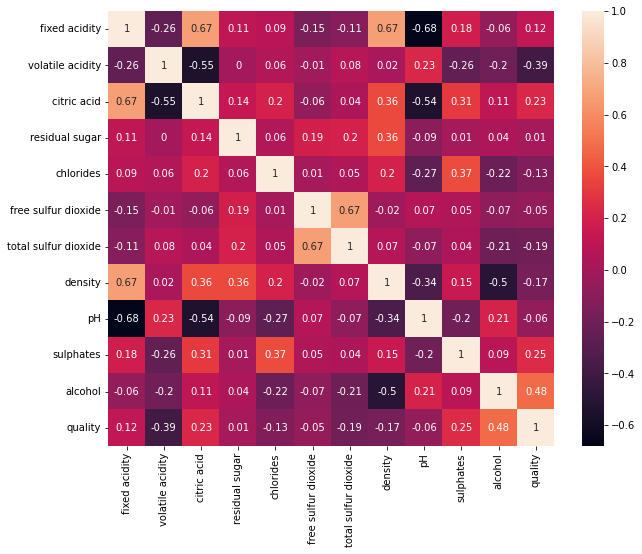

In [7]:
plt.figure(figsize=(10, 8))
sns.heatmap(round(data.corr(method="pearson"),2), annot=True)
plt.show()

## Elección de Features


A través de la gráfica es posible identificar los dos features que más se relacionan con la calidad del vino, siendo estas en una relación directamente proporcional el feature de **quality** y en una relación inversamente proporcional el feature de **volatile acidity**.

## Entrenamiento



Al igual que la Tarea 1 se utilizará el 80% del dataset como observaciones de entrenamiento.

In [12]:
# Obtener número de observaciones para entrenamiento

Data = int(data.shape[0] * 0.8)

# Muestra de los datos

X = data.loc[:Data, ['alcohol', 'volatile acidity']]
Y = data.loc[:Data, ['quality']]

##Polinomio de grado 2

In [15]:
EntrenamientoY = Y.copy()
EntrenamientoX = X.copy()

# Propiedades de la regresión polinomial:

EntrenamientoX.columns = ['a', 'b']
EntrenamientoX['ab'] = EntrenamientoX['a'] * EntrenamientoX['b']
EntrenamientoX['a^2'] = EntrenamientoX['a'] * EntrenamientoX['a']
EntrenamientoX['b^2'] = EntrenamientoX['b'] * EntrenamientoX['b']

# Creación de ntercepto:

EntrenamientoX.insert(0, '', 1)

# Número de parámetros a estimar:

K = EntrenamientoX.shape[1]

# Print - Modelo inicial de regresión:

EntrenamientoX.head()

,,a,b,ab,a^2,b^2
0,1,9.4,0.70,6.580,88.36,0.4900
1,1,9.8,0.88,8.624,96.04,0.7744
2,1,9.8,0.76,7.448,96.04,0.5776
3,1,9.8,0.28,2.744,96.04,0.0784
4,1,9.4,0.70,6.580,88.36,0.4900


### Modelo en TensorFlow



In [20]:
# Grafo:

tf.reset_default_graph()
Grafo = tf.Graph()

with Grafo.as_default():

    # Placeholders:

    X = tf.placeholder(tf.float32, shape = (None, K), name = "X")
    Y = tf.placeholder(tf.float32, shape = (None, 1), name = "Y")

    # Hiperparámetros:

    lr = tf.placeholder(tf.float32, name = "lr")

    # Coeficientes de regresión

    W = tf.Variable(tf.zeros([K, 1], tf.float32), name = "W")

    # Hipótesis de regresión múltiple:

    with tf.name_scope("Hipotesis"):
        Yhat = tf.matmul(X, W, name = "Yhat") 

    # Función de costo:

    with tf.name_scope("Costo"):
        cost = tf.divide( tf.reduce_mean(tf.pow(Yhat-Y, 2)), 2., name="Funcion_de_Costo")

    # Gradient Descent Optimizer 

    with tf.name_scope("GradientDes.Optimizer"):
        optimizer = tf.train.GradientDescentOptimizer(lr).minimize(cost) 

        # Summary:

        costSummary = tf.summary.scalar(name="Funcion_de_Costo", tensor = cost)

    # Global Variables Initializer:

    init = tf.global_variables_initializer() 

### Entrenamiento y Aplicación del modelo

In [36]:
def TrainingModeloLineal(x, y, epochs, learning_rate):

    start = time.time()
    with tf.Session(graph = Grafo) as sess: 

        writer = tf.summary.FileWriter('./multipleReg/K=%d, lr=%f' % (K, learning_rate), sess.graph)

        sess.run(init) 

        # Iteración del batch

        for epoch in range(epochs): 

            _, summary = sess.run([optimizer, costSummary], feed_dict = {X : x, Y : y, lr : learning_rate})
            
            writer.add_summary(summary, epoch+1)

            c, Modelo = sess.run([cost, W], feed_dict = {X : x, Y : y}) 
            print("Número de Epoch:", (epoch + 1),"\tCosto =", c) 

        writer.close()
        
        CostoFinal = sess.run(cost, feed_dict ={X: x, Y: y}) 
        Modelo = sess.run(W)
        
    return (Modelo)

In [37]:
Modelo = TrainingModeloLineal(EntrenamientoX, EntrenamientoY, 10, 0.0001)

Número de Epoch: 1 	Costo = 1.7039692
Número de Epoch: 2 	Costo = 0.65730226
Número de Epoch: 3 	Costo = 0.5825411
Número de Epoch: 4 	Costo = 0.5771097
Número de Epoch: 5 	Costo = 0.57662404
Número de Epoch: 6 	Costo = 0.57649106
Número de Epoch: 7 	Costo = 0.5763834
Número de Epoch: 8 	Costo = 0.5762776
Número de Epoch: 9 	Costo = 0.57617193
Número de Epoch: 10 	Costo = 0.5760664


##Polinomio de grado 3

In [40]:
EntrenamientoX2 = EntrenamientoX.copy()

# Agregamos las características a X

EntrenamientoX2['ab^2'] = EntrenamientoX2['a'] * EntrenamientoX2['b^2']
EntrenamientoX2['ba^2'] = EntrenamientoX2['b'] * EntrenamientoX2['a^2']
EntrenamientoX2['a^3'] = EntrenamientoX2['a'] ** 3
EntrenamientoX2['b^3'] = EntrenamientoX2['b'] ** 3

# Obtenemos el número de parámetros a estimar: K
K = EntrenamientoX2.shape[1]

EntrenamientoX2.head()


,,a,b,ab,a^2,b^2,ab^2,ba^2,a^3,b^3
0,1,9.4,0.70,6.580,88.36,0.4900,4.60600,61.8520,830.584,0.343000
1,1,9.8,0.88,8.624,96.04,0.7744,7.58912,84.5152,941.192,0.681472
2,1,9.8,0.76,7.448,96.04,0.5776,5.66048,72.9904,941.192,0.438976
3,1,9.8,0.28,2.744,96.04,0.0784,0.76832,26.8912,941.192,0.021952
4,1,9.4,0.70,6.580,88.36,0.4900,4.60600,61.8520,830.584,0.343000


### Modelo en TensorFlow


In [42]:
# Grafo:

tf.reset_default_graph()
Grafo = tf.Graph()

with Grafo.as_default():

    # Placeholders:

    X = tf.placeholder(tf.float32, shape = (None, K), name = "X")
    Y = tf.placeholder(tf.float32, shape = (None, 1), name = "Y")

    # Hiperparámetros:

    lr = tf.placeholder(tf.float32, name = "lr")

    # Coeficientes de regresión

    W = tf.Variable(tf.zeros([K, 1], tf.float32), name = "W")

    # Hipótesis de regresión múltiple:

    with tf.name_scope("Hipotesis"):
        Yhat = tf.matmul(X, W, name = "Yhat") 

    # Función de costo:

    with tf.name_scope("Costo"):
        cost = tf.divide( tf.reduce_mean(tf.pow(Yhat-Y, 2)), 2., name="Funcion_de_Costo")

    # Gradient Descent Optimizer 

    with tf.name_scope("GradientDes.Optimizer"):
        optimizer = tf.train.GradientDescentOptimizer(lr).minimize(cost) 

        # Summary:

        costSummary = tf.summary.scalar(name="Funcion_de_Costo", tensor = cost)

    # Global Variables Initializer:

    init = tf.global_variables_initializer() 

### Entrenamiento y Aplicación del modelo

In [43]:
def TrainingModeloLineal(x, y, epochs, learning_rate):

    start = time.time()
    with tf.Session(graph = Grafo) as sess: 

        writer = tf.summary.FileWriter('./multipleReg/K=%d, lr=%f' % (K, learning_rate), sess.graph)

        sess.run(init) 

        # Iteración del batch

        for epoch in range(epochs): 

            _, summary = sess.run([optimizer, costSummary], feed_dict = {X : x, Y : y, lr : learning_rate})
            
            writer.add_summary(summary, epoch+1)

            c, Modelo = sess.run([cost, W], feed_dict = {X : x, Y : y}) 
            print("Número de Epoch:", (epoch + 1),"\tCosto =", c) 

        writer.close()
        
        CostoFinal = sess.run(cost, feed_dict ={X: x, Y: y}) 
        Modelo = sess.run(W)
        
    return (Modelo)

In [48]:
Modelo = TrainingModeloLineal(EntrenamientoX2, EntrenamientoY, 10, 0.00001)

Número de Epoch: 1 	Costo = 3072.3308
Número de Epoch: 2 	Costo = 625385.1
Número de Epoch: 3 	Costo = 127352470.0
Número de Epoch: 4 	Costo = 25933943000.0
Número de Epoch: 5 	Costo = 5281164600000.0
Número de Epoch: 6 	Costo = 1075451360000000.0
Número de Epoch: 7 	Costo = 2.1900392e+17
Número de Epoch: 8 	Costo = 4.459774e+19
Número de Epoch: 9 	Costo = 9.081842e+21
Número de Epoch: 10 	Costo = 1.8494171e+24


## Resultados

Al analizar los valores de los costos y los learning rates utilizados es notorio que el modelo para el polinomio de grado 2 es más preciso ya que posee una reducción del costo menor cuando es comparada a los resultados obtenidos en el polinomio de grado 3.